In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
new_model=False

In [4]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: >

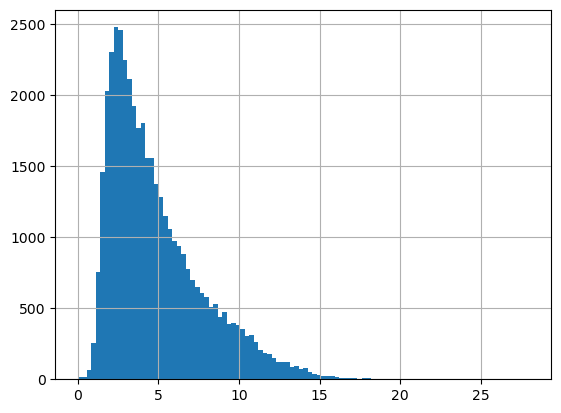

In [7]:
adata.obs.pct_counts_mt.hist(bins=100)

In [8]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K

In [9]:
sc.pp.filter_cells(adata, min_counts=100)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [10]:
sc.pp.filter_genes(adata, min_cells=1)

In [11]:
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx]

In [12]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [13]:
# Y_sums = np.array(np.sum(adata.X > 0, axis=0))[0]

# Y_nsf = np.array(adata.X[:, Y_sums>100].todense() * 100, dtype=int).T
# Y = np.array(adata.X[:].todense()*100, dtype=int).T

In [14]:
Y = Dtr['Y'].T

In [15]:
X = Dtr['X']*50.0

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:26: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


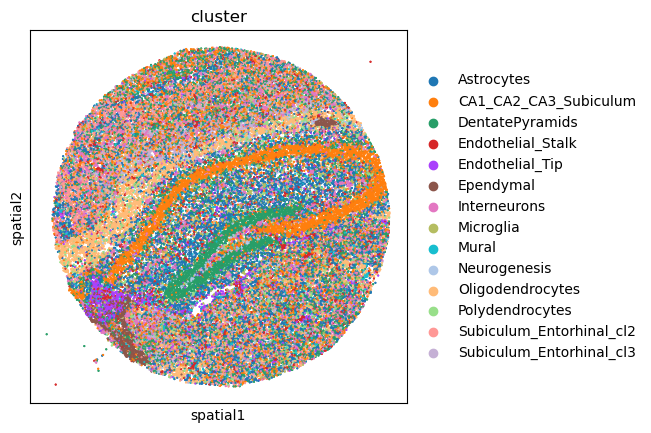

In [16]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)

# plt.figure(figsize=(10, 10))
# for i, category in enumerate(adata.obs.cluster.values.categories):
#     mask = adata.obs.cluster.values==category
#     plt.subplot(4, 4, i+1)
#     plt.title(category, fontsize=8)
#     plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
#     plt.xlim([0, 6000])
#     plt.ylim([0, 6000])
#     plt.gca().invert_yaxis()
#     plt.xticks([])
#     plt.yticks([])

In [17]:
# factors, loadings = regularized_nmf(Y.T, L=20, shrinkage=0.3, max_iter = 40, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=12)

In [18]:
# moran_idx, moranI = dims_autocorr(np.exp(factors), X)

In [19]:
# factors_ordered = factors[:, moran_idx]
# loadings_ordered = loadings[:, moran_idx]

In [20]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [21]:
L = 20
M = 3000
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=1.7)
gp = SVGP(kernel, M=M, jitter=1e-1)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

model = NSF2(gp, Y, L=L)


if not new_model:
    model.load_state_dict(torch.load('slideseq_nsf.pth'))
    
    with open("slideseq_nsf_means.pth", "rb") as fp:   
        means = pickle.load(fp)

    with open("slideseq_nsf_scales.pth", "rb") as fp:   
        scales = pickle.load(fp)

    with open("slideseq_nsf_idxs.pth", "rb") as fp:   
        idxs = pickle.load(fp)
        

model.to(device)
    

/tmp/ipykernel_1419098/1592571226.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


NSF2(
  (prior): SVGP(
    (kernel): NSF_RBF()
  )
)

In [22]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [23]:
# def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
#     losses = []
    
#     means = []
#     scales = []
    
#     for it in tqdm(range(steps)):
        
#         optimizer.zero_grad()
#         pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)

#         logpY = y*torch.log(pY.rate) - pY.rate

#         ELBO = (logpY).mean(axis=0).sum()
#         ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

#         loss = -ELBO
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())
#         if (it%10)==0:
#             means.append(torch.exp(qF.mean.detach().cpu()).numpy())
#             scales.append(qF.scale.detach().cpu().numpy())
    
#     with torch.no_grad():
#         if device.type=='cuda':
#             torch.cuda.empty_cache()
        
#     return losses, means, scales

In [24]:
X_train = X.to(device)
Y_train = Y.to(device)

In [25]:
model.prior.kernel.lengthscale = nn.Parameter(torch.ones_like(model.prior.kernel.lengthscale)*1.0)

In [26]:
model.prior.kernel.lengthscale.requires_grad = False
model.prior.kernel.sigma.requires_grad = False
model.prior.Z.requires_grad=False
model.prior.mu.requires_grad=True
model.prior.Lu.requires_grad=True

In [83]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-3)

In [28]:
# model.to(device)
# losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=17*2000, E=1, batch_size=7000)

In [46]:
# torch.save(model.state_dict(), 'slideseq_nsf.pth')
# with open("slideseq_nsf_means.pth", "wb") as fp:   
#     pickle.dump(means, fp)

# with open("slideseq_nsf_scales.pth", "wb") as fp:   
#     pickle.dump(scales, fp)

# with open("slideseq_nsf_idxs.pth", "wb") as fp:   
#     pickle.dump(idxs, fp)

In [ ]:
model.to(device)
losses, means2, scales2, idxs2 = train_batched(model, optimizer, X_train, Y_train, device, steps=9*2000, E=1, batch_size=7000)

  0%|          | 0/18000 [00:00<?, ?it/s]

In [71]:
# means = means + means2
# scales = scales + scales2
# idxs = idxs + idxs2

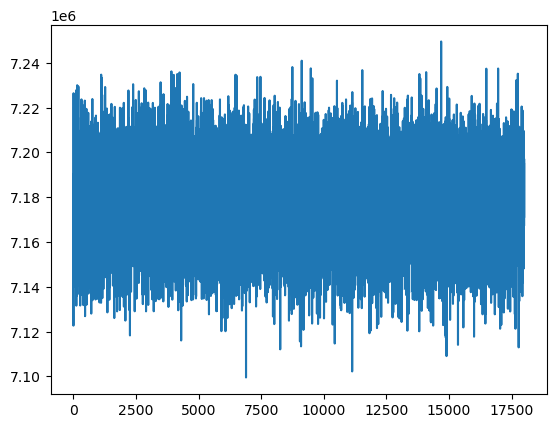

In [85]:
plt.plot(losses)

In [86]:
model.cpu()

qF, qU, pU = model.prior(X)

factors = torch.exp(qF.mean).detach().cpu().numpy()
factors_scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()


del qF, pU, qU

In [95]:
moran_idx, moranI = dims_autocorr(np.log(factors).T, X)

In [89]:
def plot(factors, moran_idx, ax=None, size=7, alpha=0.8):
    
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=0.1)

        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [90]:
def plot2(factors, moran_idx, idx, ax=None, size=7, alpha=0.8):
    
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[idx, 0], X[idx,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=0.1)
        
        curr_ax.set_xlim([X[:,0].min()*1.1, X[:,0].max()*1.1])
        curr_ax.set_ylim([X[:,1].min()*1.1, X[:,1].max()*1.1])
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

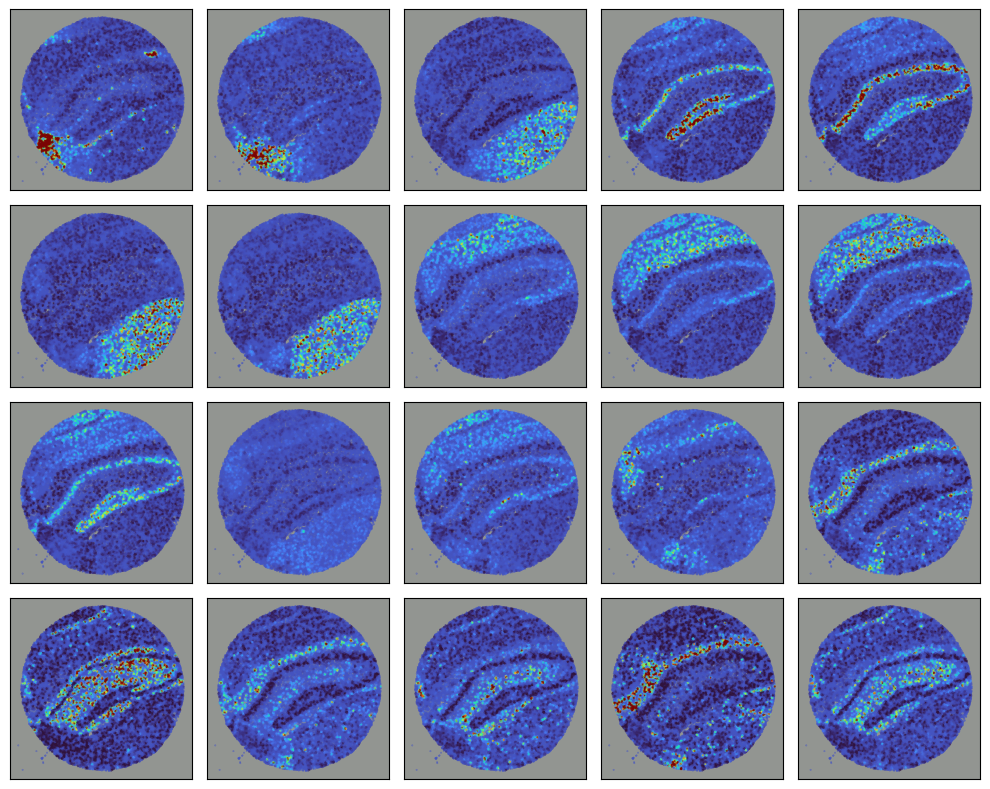

In [96]:
plot(factors, moran_idx, size=2, alpha=0.8)

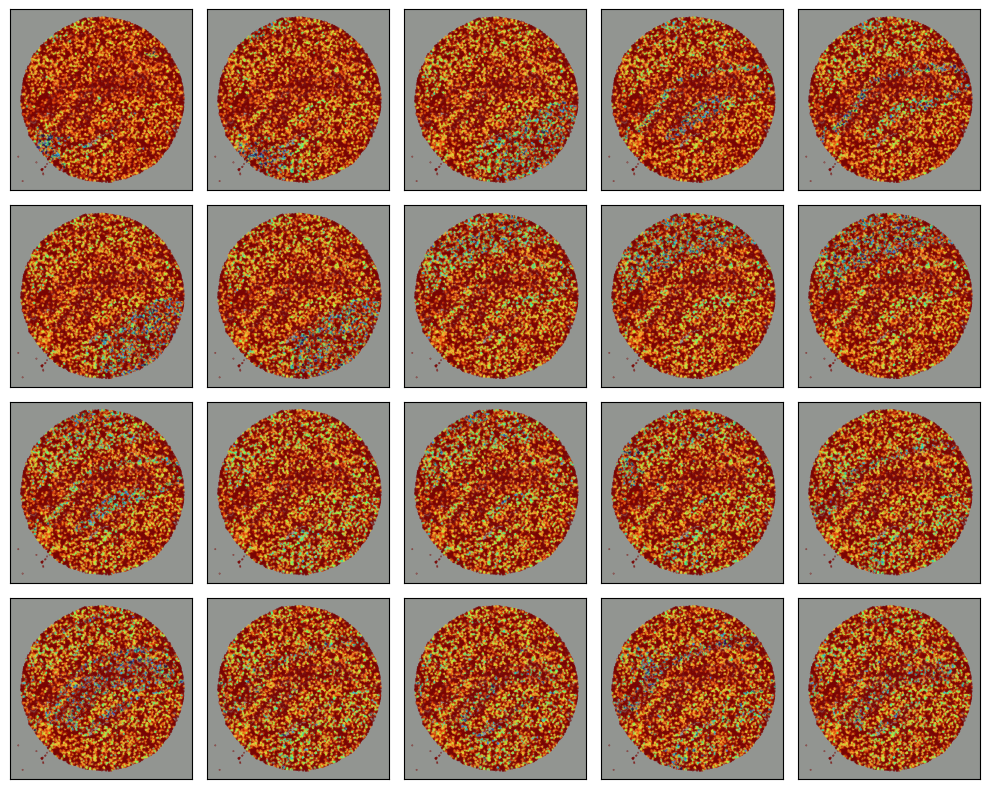

In [97]:
plot(factors_scales, moran_idx, size=2, alpha=0.8)

hi 0
hi 0
hi 45
hi 90
hi 135
hi 180
hi 225
hi 270
hi 315
hi 360
hi 405
hi 450
hi 495
hi 540
hi 585
hi 630
hi 675
hi 720
hi 765
hi 810
hi 855
hi 900
hi 945
hi 990
hi 1035
hi 1080
hi 1125
hi 1170
hi 1215
hi 1260
hi 1305
hi 1350
hi 1395
hi 1440
hi 1485
hi 1530
hi 1575
hi 1620
hi 1665
hi 1710
hi 1755
hi 1800
hi 1845
hi 1890
hi 1935
hi 1980
hi 2025
hi 2070
hi 2115
hi 2160
hi 2205
hi 2250
hi 2295
hi 2340
hi 2385
hi 2430
hi 2475
hi 2520
hi 2565
hi 2610
hi 2655
hi 2700
hi 2745
hi 2790
hi 2835
hi 2880
hi 2925
hi 2970
hi 3015
hi 3060
hi 3105
hi 3150
hi 3195
hi 3240
hi 3285
hi 3330
hi 3375
hi 3420
hi 3465
hi 3510
hi 3555
hi 3600
hi 3645
hi 3690
hi 3735
hi 3780
hi 3825
hi 3870
hi 3915
hi 3960
hi 4005
hi 4050
hi 4095
hi 4140
hi 4185
hi 4230
hi 4275
hi 4320
hi 4365
hi 4410
hi 4455
hi 4500
hi 4545
hi 4590
hi 4635
hi 4680
hi 4725
hi 4770
hi 4815
hi 4860
hi 4905


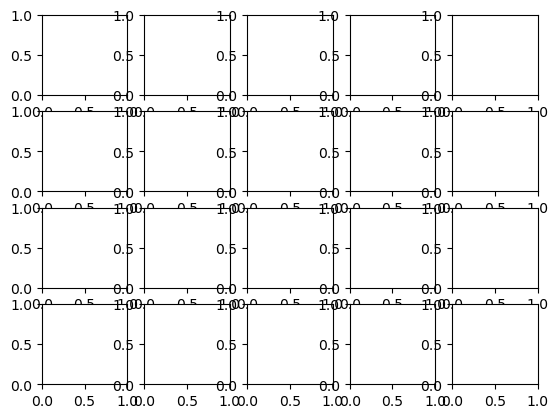

In [81]:
size=2
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
            
    
    curr_mean = means[iteration]
    curr_idx = idxs[iteration]
    
    
    plot2(curr_mean, moran_idx, curr_idx, ax=ax, size=size, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)
    


anim = FuncAnimation(fig, update, frames=np.arange(0, len(means), 45), interval=100)
plt.close()

# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("slideseq_nsf_means.mp4", fps=11, dpi=100)

hi 0
hi 0
hi 45
hi 90
hi 135
hi 180
hi 225
hi 270
hi 315
hi 360
hi 405
hi 450
hi 495
hi 540
hi 585
hi 630
hi 675
hi 720
hi 765
hi 810
hi 855
hi 900
hi 945
hi 990
hi 1035
hi 1080
hi 1125
hi 1170
hi 1215
hi 1260
hi 1305
hi 1350
hi 1395
hi 1440
hi 1485
hi 1530
hi 1575
hi 1620
hi 1665
hi 1710
hi 1755
hi 1800
hi 1845
hi 1890
hi 1935
hi 1980
hi 2025
hi 2070
hi 2115
hi 2160
hi 2205
hi 2250
hi 2295
hi 2340
hi 2385
hi 2430
hi 2475
hi 2520
hi 2565
hi 2610
hi 2655
hi 2700
hi 2745
hi 2790
hi 2835
hi 2880
hi 2925
hi 2970
hi 3015
hi 3060
hi 3105
hi 3150
hi 3195
hi 3240
hi 3285
hi 3330
hi 3375
hi 3420
hi 3465
hi 3510
hi 3555
hi 3600
hi 3645
hi 3690
hi 3735
hi 3780
hi 3825
hi 3870
hi 3915
hi 3960
hi 4005
hi 4050
hi 4095
hi 4140
hi 4185
hi 4230
hi 4275
hi 4320
hi 4365
hi 4410
hi 4455
hi 4500
hi 4545
hi 4590
hi 4635
hi 4680
hi 4725
hi 4770
hi 4815
hi 4860
hi 4905


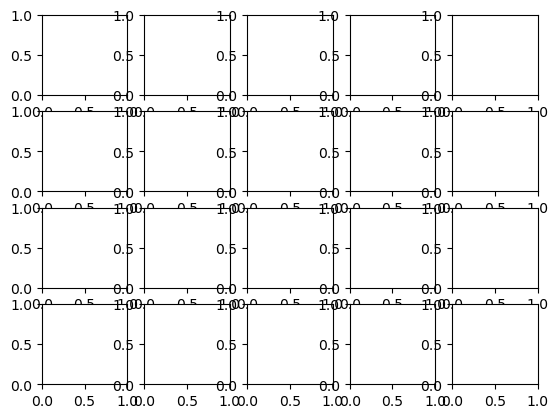

In [82]:
size=2
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
            
    
    curr_scale = scales[iteration]
    curr_idx = idxs[iteration]
    
    
    plot2(curr_scale, moran_idx, curr_idx, ax=ax, size=size, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, len(means), 45), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("slideseq_nsf_scales.mp4", fps=11, dpi=100)